# Explanatory Data Analysis for StMary

서울성모병원 외과중환자실에서 수집된 중환자 50명, 건강한 자원자 50명의 2분 Photoplethysmography(PPG), Respiratory rate(RR)의 데이터를 분석한다.

1) StMary 데이터셋의 특징을 추출하는 것은 물론이고, 

2) 중환자 데이터와 건강한 자원자 데이터를 병합해서 데이터셋을 구성해도 무방한지 등에 대해서도 검증이 필요하다.

3) 남자와 여자 데이터를 병합해서 데이터셋을 구성해도 무방한지 등에 대해서도 검증한다.

4) 또한 모델의 학습 후에 검증용으로 사용할 예정인 BIDMC, Capnobase 와 같은 데이터는 그 특징 및 성격이 StMary 데이터셋과 비교하여 어떠한지도 살펴볼 필요가 있다.

## Conclusion

EDA를 통해 서울성모병원 SICU의 데이터셋 특징을 추출할 수 있었고, 이때 남자와 여자의 두 집단은 그 신호 데이터셋에 대하여 동일한 집단이라고 볼 수 있다.

하지만 환자와 자원자 두 집단에 대하여 비교를 하였을 때는 두 집단이 동일한 집단이라고 보기 어렵다. (Ttest_indResult(statistic=-2.230645821079589, pvalue=0.02690414574560482))

그러므로 연구를 수행할 때에는 환자와 자원자는 확실히 구분할 필요가 있다.

다만, 모델 학습에 있어서 반드시 두 집단을 구분할 필요가 있을지에 대해서는 고민의 여지가 있다.

이는 모델을 학습시켜 환자와 자원자 양쪽을 다 예측할 수 있도록 일반화시키는 방안이 될 수도 있기 때문이다.

하지만 엄밀하게는 이 두 집단을 구분하여 학습시킬 필요가 있을 듯 하다.

이후에는 학습의 성과를 측정하기 위해 외부 데이터셋인 BIDMC 를 활용하고자 한다.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('ggplot')

fs = 125
window_size = fs * 60 # 7500
shift = int(window_size/4) # 1875

DATA_PATH = '../../DataLake/stMary'

In [2]:
subjects = pd.read_csv(f'{DATA_PATH}/patients.csv')
males = subjects.loc[subjects['gender']=='M']
females = subjects.loc[subjects['gender']=='F']
patients = subjects.loc[subjects['diagnosis']!='0']
volunteers = subjects.loc[subjects['diagnosis']=='0']

In [3]:
subjects

,id,diagnosis,gender,age,startMeasureTime,endMeasureTime
0,6265f66dd31b9ea93535076b,CBD obstruction,M,78,1650849393300,1650849523369
1,6265f586d31b9ea9353500c6,CBD obstruction,M,78,1650849228695,1650849358767
2,6265f32ad31b9ea93534f96d,panperitonitis,M,82,1650848561097,1650848691193
3,6265f27ad31b9ea93534f2d0,Panperitonitis,M,82,1650848401106,1650848531190
4,6265f160d31b9ea93534eb7c,Fracture of neck of femur,M,69,1650848115943,1650848245997
...,...,...,...,...,...,...
195,62380bf5269de1dfc72e4c2c,0,F,55,1647840274158,1647840404230
196,62380b3b269de1dfc72e4707,0,F,35,1647840065249,1647840195346
197,62380a8f269de1dfc72e41ae,0,F,35,1647839906079,1647840036091
198,623809de269de1dfc72e3c51,0,F,25,1647839718788,1647839848848


In [3]:
def generate_dataset(id_list):
    dataset = []
    for sid in id_list.id.unique():
        pleth = pd.read_csv(f'{DATA_PATH}/{sid}/pleth.csv', header=None, names=['sid', 'offset', 'pleth'])
        resp = pd.read_csv(f'{DATA_PATH}/{sid}/respirationTimeline.csv', header=None, names=['sid', 'offset'])
        pleth['offset'] = pleth['offset'] - pleth['offset'].min()
        resp['offset'] = (resp['offset'] - resp['offset'].min())/1000
        size_lim = int(fs * np.ceil(resp['offset'].max()))
        pleth = pleth[:size_lim]
        samp_resp = [len(resp.loc[(resp['offset']>=0+(int(shift/fs)*i)) & ((resp['offset']<int(window_size/fs)+(int(shift/fs)*i)))]) for i in range(int((len(pleth)-window_size)/shift)+1)]
        samp_pleth = [pleth[0+(shift*i):window_size+(shift*i)].pleth.values for i in range(int((len(pleth) - window_size)/shift)+1)]
        
        for i in range(len(samp_pleth)):
            temp = []
            temp.append(samp_pleth[i])
            temp.append(samp_resp[i])
            dataset.append(np.asarray(temp, dtype=object))

    return np.asarray(dataset)

In [4]:
patient_dataset = generate_dataset(patients)
volunteer_dataset = generate_dataset(volunteers)

In [5]:
print(len(patient_dataset), len(volunteer_dataset))
patient_dataset[:10][:]

489 471


array([[array([1759, 1748, 1737, ..., 2039, 2095, 2144]), 18],
       [array([1951, 1934, 1918, ..., 1216, 1210, 1211]), 17],
       [array([1773, 1794, 1813, ..., 1808, 1795, 1782]), 17],
       [array([1785, 1770, 1755, ..., 1597, 1589, 1580]), 16],
       [array([2186, 2221, 2249, ..., 1884, 1865, 1847]), 17],
       [array([1467, 1476, 1490, ..., 1850, 1844, 1841]), 18],
       [array([1380, 1380, 1380, ..., 1920, 1934, 1943]), 17],
       [array([2175, 2173, 2166, ..., 1644, 1666, 1694]), 20],
       [array([1768, 1765, 1762, ..., 1841, 1840, 1837]), 20],
       [array([1842, 1845, 1851, ..., 1465, 1460, 1455]), 19]],
      dtype=object)

## 1. Characteristic of Stmary

In [6]:
print(f'Total subjects: \t{len(subjects)}')
print(f'Total males: \t\t{len(males)}')
print(f'Total females: \t\t{len(females)}')
print(f'Total patients: \t{males.loc[males["diagnosis"]!="0", "id"].nunique()}(M)|{females.loc[females["diagnosis"]!="0", "id"].nunique()}(F)')
print(f'Total volunteers: \t{males.loc[males["diagnosis"]=="0", "id"].nunique()}(M)|{females.loc[females["diagnosis"]=="0", "id"].nunique()}(F)')
print(f'Patients age: \t\t{patients.age.mean():.2f}±{patients.age.std():.2f}')
print(f'Volunteers age: \t{volunteers.age.mean():.2f}±{volunteers.age.std():.2f}')
display(patients.groupby(by='diagnosis').count()['id'])

Total subjects: 	200
Total males: 		86
Total females: 		114
Total patients: 	56(M)|44(F)
Total volunteers: 	30(M)|70(F)
Patients age: 		61.94±16.32
Volunteers age: 	32.66±6.93


diagnosis
AGC c liver meta                           2
AML                                        2
ARDS                                       2
ASO                                        8
Aneurysm and dissection of Renal artery    1
Aneurysm and dissection of renal artery    1
Aortic aneurysm                            2
Brain death                                2
CAPD peritonitis                           2
CBD obstruction                            2
Cervical cancer                            2
DM foot                                    2
Deep neck abscess                          4
Duodenal perforation                       2
Endometrial cancer                         4
Esophageal cancer                          4
Fracture of neck of femur                  2
Fulminant hepatitis                        2
GB cancer                                  2
Gastric cancer                             2
HCC                                        2
Hepatectomy                                1


## 2. Difference Between Male and Female

남성의 PPG 신호와 여성의 PPG 신호를 합쳐서 연구에 사용해도 괜찮은지 먼저 살펴보고자 한다.

이를 위해서는 남성, 여성 샘플 각 86개, 114개 표본의 평균을 구하고자 한다. (서로 다른 두 집단)

표본들은 서로 독립적이라고 가정하며, 표본의 수가 30 이상이므로 중심극한정리에 따라 정규성을 만족한다고 본다.

등분산성을 만족하는지 `Bartlett-test`, `Levene-test`, `Fligner-test` 등을 수행하여서 검정한다.

Significant level 은 0.05로 잡는다.

In [7]:
from scipy import stats

In [8]:
col_names = ['sid', 'offset', 'pleth']
males_total_pleth = np.asarray([np.mean(pd.read_csv(f'{DATA_PATH}/{sid}/pleth.csv', header=None, names=col_names).pleth.values, axis=0) for sid in males.id.unique()])
females_total_pleth = np.asarray([np.mean(pd.read_csv(f'{DATA_PATH}/{sid}/pleth.csv', header=None, names=col_names).pleth.values, axis=0) for sid in females.id.unique()])

In [9]:
stats.bartlett(males_total_pleth, females_total_pleth)

BartlettResult(statistic=0.029323505580670005, pvalue=0.8640342117067661)

`Bartlett-test` 를 이용해서 남성, 여성 샘플 각 100개 표본의 평균값들이 등분산성을 갖는지 확인하였다.

이때 p-value가 0.864 로 유의수준 0.05 보다 값이 크다. 그러므로 1종오류를 범할 확률이 크므로, 대립가설을 기각하고 귀무가설을 채택한다.

귀무가설은 **데이터의 등분산성을 충족한다** 이다.

등분산성이 충족될 경우 `Independent two sample t-test`를 수행하여 두 집단의 평균을 비교할 수 있다.

In [10]:
stats.ttest_ind(males_total_pleth, females_total_pleth, equal_var=True)

Ttest_indResult(statistic=-1.404899941206344, pvalue=0.16161794676381397)

`Independent two sample t-test`를 수행하여 남성과 여성의 신호 두 집단의 평균이 같은지, 다른지를 확인하였다. (양측검정)

p-value가 0.162 정도로 유의수준 0.05 보다 값이 크다. 그러므로 Type-1 error를 범할 확률이 크므로, 대립가설을 기각하고 귀무가설을 채택한다.

귀무가설은 **두 집단의 평균이 같다** 이다.

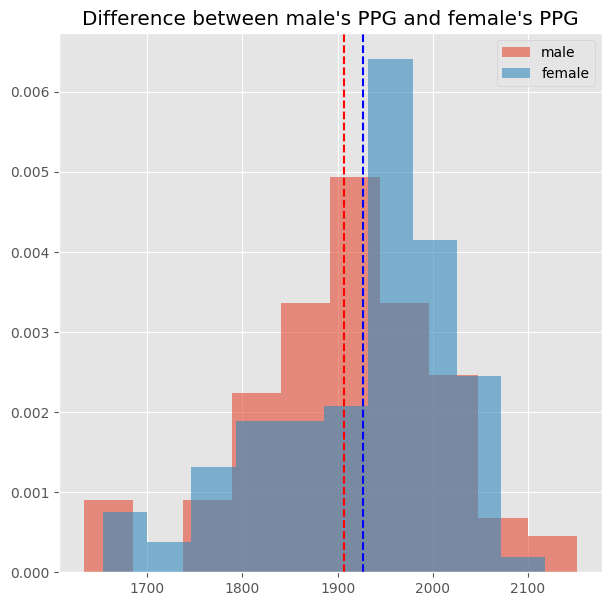

In [12]:
plt.figure(figsize=(7,7))
plt.title("Difference between male's PPG and female's PPG")
plt.hist(males_total_pleth, bins=10, density=True, alpha=0.6, label='male')
plt.axvline(males_total_pleth.mean(), linestyle='--', color='r')
plt.hist(females_total_pleth, bins=10, density=True, alpha=0.6, label='female')
plt.axvline(females_total_pleth.mean(), linestyle='--', color='b')
plt.legend()
plt.show()

## 3. Difference Between Patient and Volunteer

환자의 PPG 신호와 건강한 자원자의 PPG 신호를 합쳐서 연구에 사용해도 괜찮은지 먼저 살펴보고자 한다.

이를 위해서는 환자, 자원자 샘플 각 100개 표본의 평균을 구하고자 한다. (서로 다른 두 집단)

표본들은 서로 독립적이라고 가정하며, 표본의 수가 30 이상이므로 중심극한정리에 따라 정규성을 만족한다고 본다.

등분산성을 만족하는지 `Bartlett-test`, `Levene-test`, `Fligner-test` 등을 수행하여서 검정한다.

Significant level 은 0.05로 잡는다.

In [13]:
from scipy import stats

In [14]:
col_names = ['sid', 'offset', 'pleth']
patients_total_pleth = np.asarray([np.mean(pd.read_csv(f'{DATA_PATH}/{sid}/pleth.csv', header=None, names=col_names).pleth.values, axis=0) for sid in patients.id.unique()])
volunteers_total_pleth = np.asarray([np.mean(pd.read_csv(f'{DATA_PATH}/{sid}/pleth.csv', header=None, names=col_names).pleth.values, axis=0) for sid in volunteers.id.unique()])

In [15]:
stats.bartlett(patients_total_pleth, volunteers_total_pleth)

BartlettResult(statistic=6.983607137831417, pvalue=0.008225964645362703)

In [16]:
stats.levene(patients_total_pleth, volunteers_total_pleth)

LeveneResult(statistic=11.16751060311394, pvalue=0.0009950971859602395)

In [17]:
stats.fligner(patients_total_pleth, volunteers_total_pleth)

FlignerResult(statistic=12.108989093258293, pvalue=0.0005017933203570262)

In [18]:
# np.var(patients_total_pleth) # 11804.994545487607
# np.var(volunteers_total_pleth) # 6909.092306379008
print(f'Rule of thumb: {np.var(patients_total_pleth)/np.var(volunteers_total_pleth)}')

Rule of thumb: 1.708617286034567


이상의 세 가지 등분산성 검정을 실시하였을 때 두 집단 사이에는 등분산성이 존재하지 않음을 알 수 있다.

등분산성이 존재하지 않는 경우, 자유도를 수정한 강건한 t-test 인 `Welch t-test` 를 수행할 수 있다.

In [19]:
stats.ttest_ind(patients_total_pleth, volunteers_total_pleth, equal_var=False)

Ttest_indResult(statistic=-2.230645821079589, pvalue=0.02690414574560482)

`Welch t-test`를 수행하여 환자와 자원자의 신호 두 집단의 평균이 동일한지 아닌지를 확인하였다.(양측검정)

p-value가 약 0.027 정도로 유의수준 0.05 보다 값이 작다.

또한 z-score 가 -2.23 정도로 -1.96 보다 값이 작다.

그러므로 Type-1 error를 범할 확률이 작으므로, 대립가설을 채택하고 귀무가설을 기각한다.

대립가설은 **두 집단이 서로 다르다(두 집단의 평균이 다르다)** 이다.

다만, 인공지능의 학습 범주가 무엇이냐에 있어서는 두 집단이 서로 다르더라도 모델의 일반화를 위해서 학습시키는 것도 유의미하다.

In [21]:
# 추가 two-sample z-test
from statsmodels.stats.weightstats import ztest

ztest(patients_total_pleth, volunteers_total_pleth)

(-2.230645821079589, 0.02570459907168442)

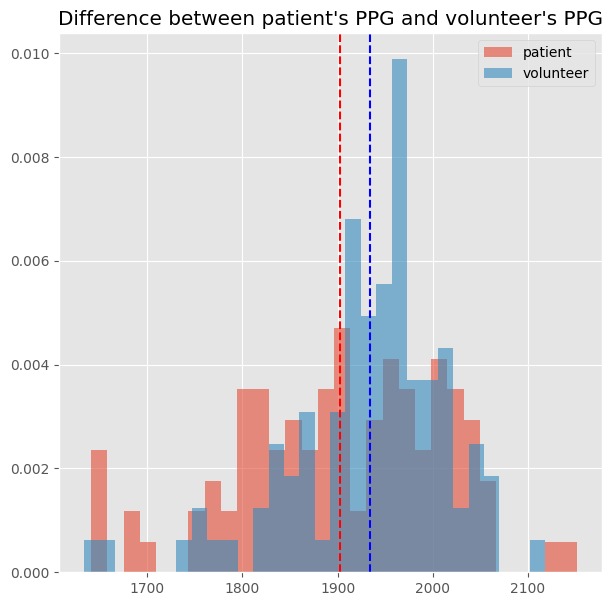

In [20]:
plt.figure(figsize=(7,7))
plt.title("Difference between patient's PPG and volunteer's PPG")
plt.hist(patients_total_pleth, bins=30, density=True, alpha=0.6, label='patient')
plt.axvline(patients_total_pleth.mean(), linestyle='--', color='r')
plt.hist(volunteers_total_pleth, bins=30, density=True, alpha=0.6, label='volunteer')
plt.axvline(volunteers_total_pleth.mean(), linestyle='--', color='b')
plt.legend()
plt.show()

## 4. Compare with BIDMC, Capnobase

In [31]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('ggplot')

fs = 125
window_size = fs * 60 # 7500
shift = int(window_size/4) # 1875

### 4.1. BIDMC

BIDMC는 125Hz로 샘플링된 신호 데이터와 1Hz 샘플링된 수치 데이터를 가진다.

본 연구에서는 단순화를 위해 1분(125*60)의 데이터를 1분당 호흡수와 대응시킨 데이터셋을 준비한다.

In [32]:
DATA_PATH2 = '../../DataLake/bidmc_csv'
regex = re.compile('bidmc_[0-9]+')

In [33]:
bidmc_id = sorted(list(set([regex.match(filename.name).group() for filename in os.scandir(DATA_PATH2)])))

In [34]:
bidmc_dataset = []
for sid in bidmc_id:
    pleth = pd.read_csv(f'{DATA_PATH2}/{sid}_Signals.csv', usecols=['Time [s]', ' PLETH'])
    resp = pd.read_csv(f'{DATA_PATH2}/{sid}_Numerics.csv', usecols=['Time [s]', ' RESP'])

    samp_pleth = [pleth[0+shift*i:window_size+shift*i][' PLETH'].values for i in range(int((len(pleth)-window_size)/shift)+1)]
    samp_resp = [round(np.mean(resp[0+int(shift/fs)*i:int(window_size/fs)+int(shift/fs)*i][' RESP'])) for i in range(int((len(pleth)-window_size)/shift)+1)]

    for i in range(len(samp_pleth)):
        temp = []
        temp.append(samp_pleth[i])
        temp.append(samp_resp[i])
        bidmc_dataset.append(np.asarray(temp, dtype=object))

bidmc_dataset = np.asarray(bidmc_dataset)
print(bidmc_dataset.shape) # 53개 레코드 각 29개 표본 추출


(1537, 2)


### 4.2. CapnoBase

CapnoBase는 42개 레코드의 8분 PPG 신호 데이터를 갖고 있다.

Sampling rate는 300Hz 이다.

유아와 성인 환자들이 섞여 있는데 적합한지는 의문스럽다.

굳이 capnobase 까지 써야할까 싶다.

In [87]:
fs = 300
window_size = fs * 60 # 18000
shift = int(window_size/4) # 4500

In [88]:
DATA_PATH3 = '../../DataLake/Capnobase/data/csv'
regex = re.compile('[0-9]{4}_8min')

In [89]:
capno_id = sorted(list(set([regex.match(filename.name).group() for filename in os.scandir(DATA_PATH3)])))

In [109]:
capno_dataset = []
for sid in capno_id:
    pleth = pd.read_csv(f'{DATA_PATH3}/{sid}_signal.csv', usecols=['pleth_y'])
    resp_x = np.asarray(pd.read_csv(f'{DATA_PATH3}/{sid}_reference.csv')['rr_co2_x'][0].strip().split(' ')).reshape(-1,1)
    resp_y = np.asarray(pd.read_csv(f'{DATA_PATH3}/{sid}_reference.csv')['rr_co2_y'][0].strip().split(' ')).reshape(-1,1)
    resp = np.concatenate((resp_x, resp_y), axis=1)
    resp = pd.DataFrame(resp, columns=['resp_x', 'resp_y'], dtype=np.float16)

    print(resp)

    samp_pleth = [pleth[0+shift*i:window_size+shift*i]['pleth_y'] for i in range(int((len(pleth)-window_size)/shift)+1)]
    samp_resp = [round(np.mean(resp.loc[(resp['resp_x']>=(0+int(shift/fs)*i)) & (resp['resp_x']<int(window_size/fs)+int(shift/fs)*i)]['resp_y'].values)) for i in range(int((len(pleth)-window_size)/shift)+1)]

    for i in range(len(samp_pleth)):
        temp = []
        temp.append(samp_pleth[i])
        temp.append(samp_resp[i])
        capno_dataset.append(np.asarray(temp, dtype=object))

capno_dataset = np.asarray(capno_dataset)
print(capno_dataset.shape)

        resp_x     resp_y
0     21.53125  17.984375
1     24.87500  17.984375
2     28.15625  18.250000
3     31.53125  17.796875
4     34.78125  18.406250
..         ...        ...
146  481.75000  20.171875
147  484.75000  19.234375
148  487.75000  19.875000
149  490.75000  19.421875
150  494.00000  19.875000

[151 rows x 2 columns]
         resp_x     resp_y
0     19.421875  28.578125
1     21.515625  28.531250
2     23.640625  28.250000
3     25.781250  28.031250
4     27.890625  28.531250
..          ...        ...
224  486.500000  28.937500
225  488.500000  27.953125
226  490.750000  29.171875
227  492.750000  27.781250
228  494.750000  29.218750

[229 rows x 2 columns]
        resp_x     resp_y
0    22.171875  10.023438
1    28.171875  10.007812
2    34.187500   9.960938
3    40.187500  10.015625
4    46.156250  10.039062
..         ...        ...
74  466.000000  10.070312
75  472.000000  10.031250
76  478.000000   9.945312
77  484.000000   9.976562
78  490.000000  10.007812

[79

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in divide
  ret = arr.dtype.type(ret / rcount)


ValueError: cannot convert float NaN to integer

In [99]:
resp_x = np.asarray(pd.read_csv(f'{DATA_PATH3}/{capno_id[0]}_reference.csv')['rr_co2_x'][0].strip().split(' ')).reshape(-1,1)
resp_y = np.asarray(pd.read_csv(f'{DATA_PATH3}/{capno_id[0]}_reference.csv')['rr_co2_y'][0].strip().split(' ')).reshape(-1,1)
resp = np.concatenate((resp_x, resp_y), axis=1)
resp = pd.DataFrame(resp, columns=['resp_x', 'resp_y'], dtype=np.float16)

In [105]:
[round(np.mean(resp.loc[(resp['resp_x']>=(0+int(shift/fs)*i)) & (resp['resp_x']<int(window_size/fs)+int(shift/fs)*i)]['resp_y'].values)) for i in range(int((len(pleth)-window_size)/shift)+1)]

[18,
 18,
 18,
 18,
 18,
 17,
 17,
 18,
 18,
 18,
 18,
 19,
 20,
 21,
 21,
 21,
 20,
 20,
 20,
 20,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 20,
 20]

### 4.3. Compare stMary with BIDMC

In [116]:
from scipy import stats

In [124]:
col_names = ['sid', 'offset', 'pleth']
stmary_pleth = np.asarray([np.mean(pd.read_csv(f'{DATA_PATH}/{sid}/pleth.csv', header=None, names=col_names).pleth.values, axis=0) for sid in patients.id.unique()])
bidmc_pleth = np.asarray([np.mean(pd.read_csv(f'{DATA_PATH2}/{sid}_Signals.csv', usecols=['Time [s]', ' PLETH'])[' PLETH'].values, axis=0) for sid in bidmc_id])
print(stmary_pleth.shape, bidmc_pleth.shape)

(100,) (53,)


In [134]:
scaled_stmary_pleth = (stmary_pleth - stmary_pleth.min())/(stmary_pleth.max() - stmary_pleth.min())
scaled_bidmc_pleth = (bidmc_pleth - bidmc_pleth.min())/(bidmc_pleth.max() - bidmc_pleth.min())

In [139]:
scaled_stmary_pleth

array([0.5608812 , 0.51785177, 0.32098997, 0.28679674, 0.70475638,
       0.69284515, 0.34398201, 0.27287968, 0.78422451, 0.73578647,
       0.46667776, 0.47369773, 0.31212233, 0.34049664, 0.3369354 ,
       0.31024865, 0.40577912, 0.44466166, 0.41780359, 0.43964377,
       0.49853685, 0.53180997, 0.45287477, 0.47014998, 0.5962023 ,
       0.56506479, 0.75635486, 0.75865222, 0.73898877, 0.73113901,
       0.64775661, 0.68497243, 0.67310437, 0.72110248, 0.46682588,
       0.39290689, 0.63728309, 0.62722165, 1.        , 0.94062697,
       0.39421628, 0.37151261, 0.6110545 , 0.57599746, 0.7362125 ,
       0.7032443 , 0.78496463, 0.79076258, 0.5993447 , 0.80483661,
       0.61124595, 0.60253162, 0.76953568, 0.6728277 , 0.49013213,
       0.52364934, 0.59901339, 0.52233485, 0.63532764, 0.6298662 ,
       0.02846256, 0.        , 0.3311741 , 0.35603293, 0.60663686,
       0.52102185, 0.24705098, 0.25398228, 0.35653686, 0.41865882,
       0.02434546, 0.08126594, 0.13230553, 0.09057664, 0.64884

In [140]:
scaled_bidmc_pleth

array([0.04510608, 0.04682298, 0.0201697 , 0.02057451, 0.06430595,
       0.01396873, 0.04820357, 0.04475325, 0.04642563, 0.03095074,
       0.04068826, 0.05313317, 0.02247091, 0.05018397, 0.0601263 ,
       0.02393773, 0.03281853, 0.02636666, 0.06550024, 0.05739245,
       0.05445142, 0.05775965, 0.        , 0.04782319, 0.04768436,
       0.04818814, 0.03333279, 0.05214455, 0.04260443, 0.01558319,
       0.05850096, 0.06300289, 0.04991742, 0.05522036, 0.05652004,
       0.02137056, 0.04565282, 0.05239482, 0.04680596, 0.99765575,
       0.05020784, 0.874909  , 0.05649382, 1.        , 0.97013879,
       0.94320882, 0.93512366, 0.9404838 , 0.02923316, 0.06296928,
       0.03639267, 0.88733998, 0.91845844])

In [135]:
stats.bartlett(scaled_stmary_pleth, scaled_bidmc_pleth)

BartlettResult(statistic=15.727851212013526, pvalue=7.31392939375778e-05)

In [136]:
stats.ttest_ind(scaled_stmary_pleth, scaled_bidmc_pleth, equal_var=False)

Ttest_indResult(statistic=6.164472379167325, pvalue=3.362547301482889e-08)

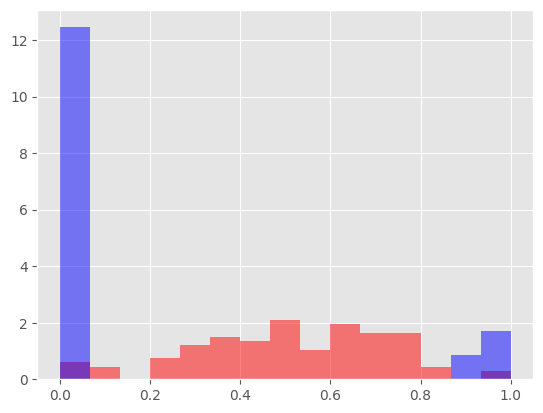

In [138]:
plt.hist(scaled_stmary_pleth, bins=15, density=True, alpha=0.5, label='stmary', color='r')
plt.hist(scaled_bidmc_pleth, bins=15, density=True, alpha=0.5, label='bidmc', color='b')
plt.show()